## Efficient Frontier

**Joshua and Jingwen**

The Efficient Frontier represents the set of optimal portfolios offering the highest expected return for a given level of risk. It is derived by analyzing different portfolio combinations and plotting risk (measured by standard deviation) against expected return. Any portfolio below the frontier is suboptimal, as higher returns could be achieved for the same risk level.

### Initialization

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting

In [7]:
# Load S&P 500 prices
sp500_prices = pd \
    .read_csv("../data/raw/tessa_sp500_prices.csv") \
    .drop(columns=['GEV', 'SOLV', 'SW']) \
    .iloc[: , 1:]
# Filter date to be between 1st mar 2024 to 28 feb 2025
sp500_prices = sp500_prices[
    (sp500_prices["date"] >= "2024-03-01") &
    (sp500_prices["date"] <= "2025-02-28")
].set_index("date", inplace=False)
    
# Load NCI prices
nci_prices = pd \
    .read_csv("../data/raw/tessa_nci_prices.csv") \
    .iloc[: , 1:]
# Filter date to be between 1st mar 2024 to 28 feb 2025
nci_prices = nci_prices[
    (nci_prices["date"] >= "2024-03-01") &
    (nci_prices["date"] <= "2025-02-28")
].set_index("date", inplace=False)

# Left join on S&P
data = pd.merge(sp500_prices, nci_prices, on="date", how="left")

data

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,ZTS,ADA-USD,AVAX-USD,BTC-USD,ETH-USD,LINK-USD,LTC-USD,SOL-USD,UNI-USD,XRP-USD
date,,,,,,,,,,,,,,,,,,,,,
2024-03-01,138.101761,178.815674,172.621796,159.720001,116.250908,82.889824,376.331512,570.929993,192.052322,52.261391,...,188.806396,0.719081,42.855328,62440.632812,3435.053955,20.060907,85.084114,129.990402,0.000275,0.601890
2024-03-04,141.875565,174.277084,170.827164,158.089996,117.642548,82.861298,379.018250,567.940002,191.481812,51.278603,...,185.877625,0.771294,43.088238,68330.414062,3630.433838,20.448757,88.935455,133.194580,0.000301,0.650133
2024-03-05,143.355301,169.320511,172.863022,159.330002,116.113716,83.099022,372.271790,544.840027,186.701126,51.509846,...,183.275375,0.693490,39.500137,63801.199219,3554.964600,19.010521,82.041199,125.706711,0.000192,0.592901
2024-03-06,145.212418,168.325180,174.696228,163.869995,116.956528,84.458809,376.173462,543.090027,188.570129,52.174675,...,181.593307,0.733821,41.514336,66106.804688,3819.226318,20.075966,85.829971,130.742020,0.000198,0.612253
2024-03-07,148.281128,168.205765,174.223465,163.539993,118.504967,83.384293,382.179169,556.039978,195.003342,52.271023,...,179.594620,0.744742,43.290005,66925.484375,3874.347656,20.127426,88.108047,143.977859,0.000214,0.628624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-24,135.279999,247.100006,204.080002,144.820007,134.949997,89.550003,363.910004,444.420013,235.963364,48.400002,...,165.309998,0.682202,21.880913,91418.171875,2513.821289,15.247294,114.461426,141.989487,0.000184,2.277929
2025-02-25,134.179993,247.039993,204.139999,141.550003,135.820007,90.349998,362.950012,443.410004,234.280685,48.759998,...,168.529999,0.682582,21.931368,88736.171875,2493.592529,15.294460,114.614510,144.107758,0.000178,2.320717
2025-02-26,134.470001,240.360001,203.009995,144.029999,135.960007,89.570000,358.350006,441.500000,232.717484,46.980000,...,164.990005,0.645038,21.797014,84347.023438,2331.452637,15.207540,124.621742,134.831329,0.000169,2.192435


In [8]:
# Check for NA values in the DataFrame
na_check = data.isna().sum()
print("NA values in each column:\n", na_check[na_check > 0])

NA values in each column:
 Series([], dtype: int64)


## Calculating EF Using Mean Daily Return (Optimise for Max Sharpe)

In [9]:
# Calculate expected returns and sample covariance
mu = ((data - data.shift(1)) / data.shift(1)).dropna().mean()
S = risk_models.CovarianceShrinkage(data).ledoit_wolf()
mu.sort_values()

MRNA      -0.003633
ENPH      -0.002547
DLTR      -0.002479
AMD       -0.002438
EL        -0.002392
             ...   
UAL        0.003348
TPL        0.004577
VST        0.004643
PLTR       0.005736
XRP-USD    0.006856
Length: 507, dtype: float64

In [10]:
# Instantiate EF problem
ef = EfficientFrontier(mu, S, solver='SCS')
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 0.2%
Annual volatility: 8.5%
Sharpe Ratio: 0.03


(0.0024086806441591915, 0.08517103161408382, 0.02828051508255882)

/Users/joshuakoh/cryptoto/.venv/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


Expected annual return: 0.7%
Annual volatility: 85.3%
Sharpe Ratio: 0.01
(0.006755841523862727, 0.8527191909514515, 0.007922703740635481)


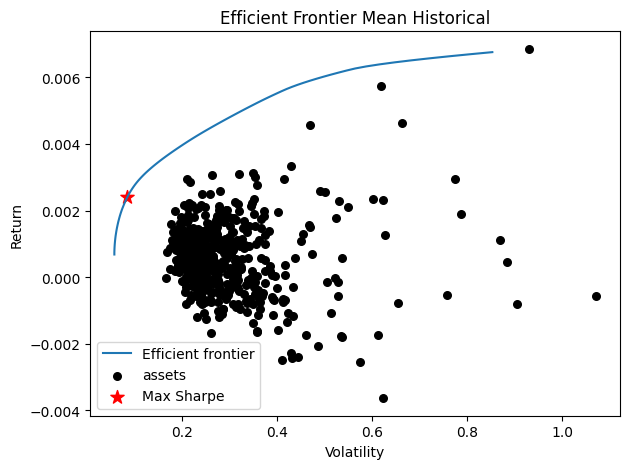

In [11]:
ef = EfficientFrontier(mu, S,
    solver='SCS'
)

# Generate plot
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance(risk_free_rate=0.0431)
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Log performance
print(ef.portfolio_performance(verbose=True))

# Output
ax.set_title("Efficient Frontier Mean Historical")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

## Calculating EF Using Mean Yearly Return (Optimise for Max Sharpe)

In [12]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(data, compounding=False)
S = risk_models.CovarianceShrinkage(data).ledoit_wolf()
mu.sort_values()

MRNA      -0.915459
ENPH      -0.641741
DLTR      -0.624820
AMD       -0.614313
EL        -0.602836
             ...   
UAL        0.843659
TPL        1.153516
VST        1.169999
PLTR       1.445504
XRP-USD    1.727667
Length: 507, dtype: float64

In [13]:
# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S, solver='SCS')
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 60.7%
Annual volatility: 8.5%
Sharpe Ratio: 7.13


(0.6069749046397781, 0.0851689691158798, 7.126714235720476)

/Users/joshuakoh/cryptoto/.venv/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


Expected annual return: 172.8%
Annual volatility: 93.0%
Sharpe Ratio: 1.86
(1.7275668837280278, 0.9300814442520594, 1.8574361357324785)


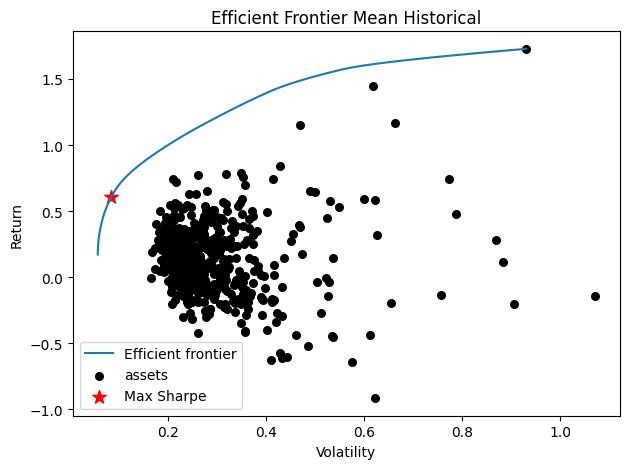

In [14]:
# Instantiate EF problem
ef = EfficientFrontier(mu, S,
    solver='SCS'
)

# Generate plot
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance(risk_free_rate=0.0431)
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Log performance
print(ef.portfolio_performance(verbose=True))

# Output
ax.set_title("Efficient Frontier Mean Historical")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

## Calculating EF Using CAPM

### Creating a function that allows us to get our final portfolio later

We will narrow down our portfolio to a size of 30, and aim to have a substantial amount of cryptocurrencies

In [15]:
def get_clean_weights_portfolio(ef,narrow_down=0) -> dict[str, float]:
    """
    This function get the clean weights portfolio and print logging information of portfolio and cryptocurrencies.

    Parameters
    ----------
    ef : EfficientFrontier
        An Efficient Frontier object after maximising objective function.
    narrow_down : int, optional
        The number of assets to narrow down. If 0, all assets are included. The default is 0.
        All cryptocurrencies are included in the portfolio.
    """
    # Get weights
    weights = ef.clean_weights()
    # Get the Assets with non-zero weights, in descending order
    weighted_portfolio = {e[0]: e[1] for e in sorted(list(weights.items()), key=lambda x: -x[1]) if e[1] > 0}
    print(len(weighted_portfolio), "initial assets in the portfolio before narrowing down")
    # Get the non-crypto asset information
    print(f"\nNon-crypto assets in the portfolio")
    non_crypto_portfolio = {pair[0]:pair[1] for pair in weighted_portfolio.items() if not pair[0].endswith("USD")}
    print(non_crypto_portfolio)
    # Get crypto asset information
    print(f"\nCrypto assets in the portfolio")
    crypto_portfolio = {pair[0]:pair[1] for pair in weighted_portfolio.items() if pair[0].endswith("USD")}
    print(crypto_portfolio)
    print(f"total weightage = {sum(crypto_portfolio.values())*100}%")
    # Narrow down the portfolio

    if narrow_down > 0:
        crpyto_assets = list(crypto_portfolio.keys())
        crypto_weightages = list(crypto_portfolio.values())
        non_crypto_asset_count = narrow_down - len(crpyto_assets)
        # Narrow down the portfolio
        assets = list(non_crypto_portfolio.keys())[:non_crypto_asset_count] + crpyto_assets
        weightages = list(non_crypto_portfolio.values())[:non_crypto_asset_count] + crypto_weightages

        adjusted_weightages = [w / sum(weightages) for w in weightages]
        starting_portfolio = {a: w for a, w in zip(assets, adjusted_weightages)}
        if sum(adjusted_weightages) != 1:
            print(f"Adjusted weightages do not sum to 1: {sum(adjusted_weightages)}")
            raise ValueError("Adjusted weightages do not sum to 1")
    else:
        starting_portfolio = weighted_portfolio
    
    return starting_portfolio

#### Getting mean returns and standard deviations

In [16]:
# Calculate expected returns and sample covariance
mu = expected_returns.capm_return(data, risk_free_rate=0.0431)
S = risk_models.CovarianceShrinkage(data).ledoit_wolf()

In [17]:
mu
mu.sort_values()

CBOE        0.014192
K           0.026110
CME         0.048219
PG          0.059076
JNPR        0.061615
              ...   
ETH-USD     0.334467
ADA-USD     0.370209
SOL-USD     0.372797
LINK-USD    0.400860
AVAX-USD    0.440374
Name: mkt, Length: 507, dtype: float64

### Optimise for Max Sharpe

/Users/joshuakoh/cryptoto/.venv/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


Expected annual return: 10.0%
Annual volatility: 6.4%
Sharpe Ratio: 1.55
(0.09955981899819033, 0.06416479976410193, 1.5516267387136886)


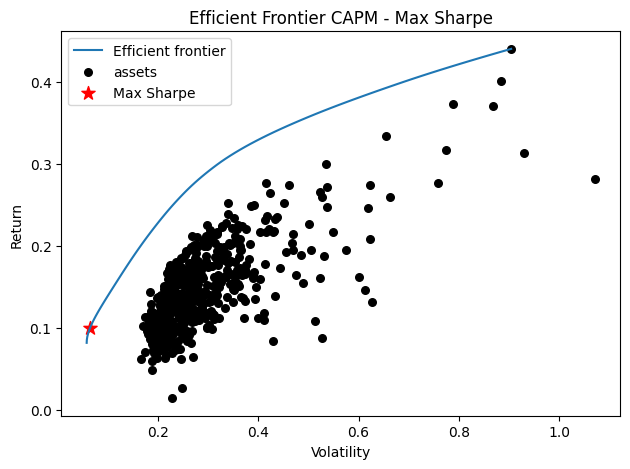

In [18]:
# Instantiate EF problem
ef = EfficientFrontier(mu, S,
    solver='SCS',
    weight_bounds=(0,1)
)

# Generate plot
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
w = ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance(risk_free_rate=0.0431)
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Log performance
print(ef_max_sharpe.portfolio_performance(risk_free_rate=0.0431,verbose=True))

# Output
ax.set_title("Efficient Frontier CAPM - Max Sharpe")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [19]:
get_clean_weights_portfolio(ef_max_sharpe,narrow_down=30)

133 initial assets in the portfolio before narrowing down

Non-crypto assets in the portfolio
{'JNPR': 0.06412, 'K': 0.04191, 'CBOE': 0.03939, 'CME': 0.03097, 'MRK': 0.02122, 'AAPL': 0.01994, 'EXPD': 0.01878, 'HOLX': 0.01846, 'JNJ': 0.01825, 'BDX': 0.01735, 'CHD': 0.01617, 'EXE': 0.01597, 'T': 0.01509, 'BG': 0.01429, 'MCK': 0.01374, 'RTX': 0.01368, 'AME': 0.01361, 'GOOGL': 0.01276, 'DIS': 0.01271, 'KDP': 0.01227, 'PM': 0.012, 'NVDA': 0.01162, 'WMT': 0.01162, 'CL': 0.01159, 'ABNB': 0.01158, 'AZO': 0.01119, 'EA': 0.01107, 'MSFT': 0.01097, 'NTAP': 0.01087, 'WTW': 0.01083, 'KO': 0.01067, 'MO': 0.01067, 'TKO': 0.01031, 'TTWO': 0.00977, 'GOOG': 0.00974, 'ACN': 0.00973, 'EW': 0.00899, 'XOM': 0.00888, 'MKTX': 0.00883, 'HPE': 0.0087, 'MLM': 0.00864, 'DOW': 0.00859, 'UBER': 0.00851, 'VZ': 0.00851, 'FANG': 0.00845, 'ULTA': 0.00844, 'TSN': 0.0081, 'PG': 0.00804, 'COP': 0.00797, 'NOC': 0.00793, 'APD': 0.00777, 'NTRS': 0.00771, 'EOG': 0.00767, 'CMS': 0.0075, 'COR': 0.00746, 'AVGO': 0.00739, 'FDX': 0

{'JNPR': 0.11991322561340514,
 'K': 0.07837746858168762,
 'CBOE': 0.07366472172351886,
 'CME': 0.05791816277678038,
 'MRK': 0.03968432076600838,
 'AAPL': 0.03729054458408139,
 'EXPD': 0.03512118491921006,
 'HOLX': 0.03452274087372831,
 'JNJ': 0.03413001196888091,
 'BDX': 0.0324468880909635,
 'CHD': 0.030240125673249553,
 'EXE': 0.029866098144823463,
 'T': 0.028220377019748652,
 'BG': 0.026724266906044288,
 'MCK': 0.025695691202872534,
 'RTX': 0.025583482944344704,
 'AME': 0.025452573309395574,
 'GOOGL': 0.023862956313584684,
 'DIS': 0.02376944943147816,
 'KDP': 0.022946588868940753,
 'PM': 0.02244165170556553,
 'NVDA': 0.021730999401555956,
 'WMT': 0.021730999401555956,
 'CL': 0.021674895272292043,
 'ABNB': 0.021656193895870736,
 'AZO': 0.02092684021543986,
 'EA': 0.020702423698384202,
 'MSFT': 0.020515409934171155,
 'NTAP': 0.02032839616995811,
 'UNI-USD': 0.002861310592459605}

### Optimise for Max Quadratic Utility

Expected annual return: 31.6%
Annual volatility: 36.1%
Sharpe Ratio: 0.76
(0.3163071954255895, 0.36081552145814666, 0.7571935772648865)


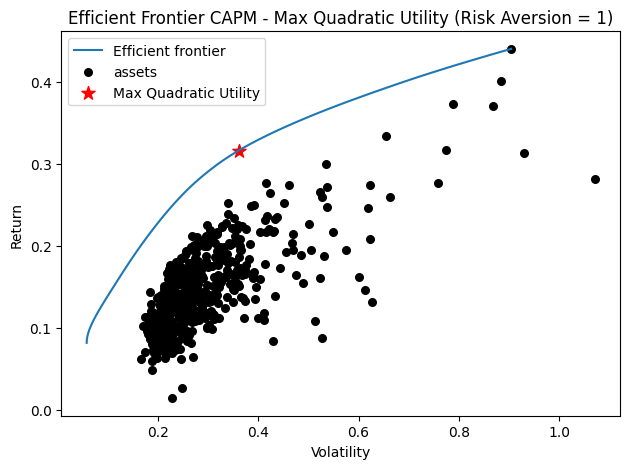

In [30]:
# Instantiate EF problem
ef = EfficientFrontier(mu, S,
    solver='SCS',
    weight_bounds=(0,1)
)

# Generate plot
fig, ax = plt.subplots()
ef_max_quadratic_utility = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
w = ef_max_quadratic_utility.max_quadratic_utility(risk_aversion=1)
ret_tangent, std_tangent, _ = ef_max_quadratic_utility.portfolio_performance(risk_free_rate=0.0431)
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Quadratic Utility")

# Log performance
print(ef_max_quadratic_utility.portfolio_performance(risk_free_rate=0.0431,verbose=True))

# Output
ax.set_title("Efficient Frontier CAPM - Max Quadratic Utility (Risk Aversion = 1)")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [31]:
get_clean_weights_portfolio(ef_max_quadratic_utility,narrow_down=30)

10 initial assets in the portfolio before narrowing down

Non-crypto assets in the portfolio
{'CZR': 0.23247, 'INTC': 0.19802, 'BLDR': 0.12269, 'MHK': 0.07532, 'ON': 0.07004, 'ALB': 0.0151, 'URI': 0.01273}

Crypto assets in the portfolio
{'AVAX-USD': 0.18007, 'SOL-USD': 0.0702, 'LINK-USD': 0.02334}
total weightage = 27.361%


{'CZR': 0.23247464949298988,
 'INTC': 0.1980239604792096,
 'BLDR': 0.12269245384907698,
 'MHK': 0.0753215064301286,
 'ON': 0.07004140082801656,
 'ALB': 0.015100302006040121,
 'URI': 0.012730254605092101,
 'AVAX-USD': 0.18007360147202944,
 'SOL-USD': 0.07020140402808056,
 'LINK-USD': 0.023340466809336186}

### Optimise Min Semideviation for Target Return

Instead of penalising volatility, mean-semivariance optimization seeks to only penalise downside volatility, since upside volatility may be desirable.

Expected annual return: 30.0%
Annual volatility: 32.0%
Sharpe Ratio: 0.80
(0.3000000003717156, 0.31979311317020326, 0.803331872362698)


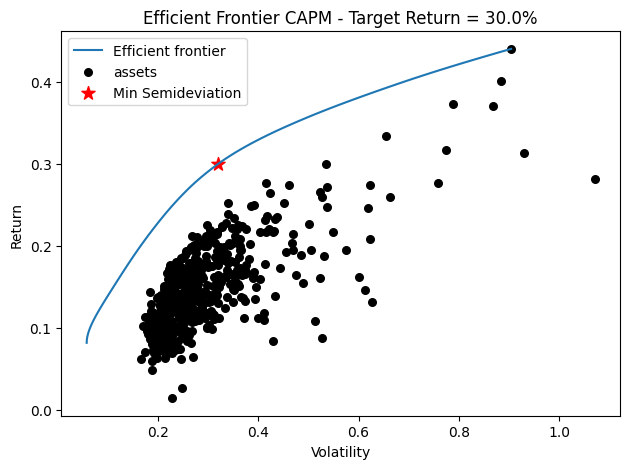

In [32]:
# Instantiate EF problem
ef = EfficientFrontier(mu, S,
    solver='SCS',
    weight_bounds=(0,1)
)

# Generate plot
fig, ax = plt.subplots()
ef_min_semideviation_for_target_return = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
target_return = 0.3
w = ef_min_semideviation_for_target_return.efficient_return(target_return=target_return)
ret_tangent, std_tangent, _ = ef_min_semideviation_for_target_return.portfolio_performance(risk_free_rate=0.0431)
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Semideviation")

# Log performance
print(ef_min_semideviation_for_target_return.portfolio_performance(risk_free_rate=0.0431,verbose=True))

# Output
ax.set_title(f"Efficient Frontier CAPM - Target Return = {target_return*100}%")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [33]:
get_clean_weights_portfolio(ef_min_semideviation_for_target_return,narrow_down=30)

12 initial assets in the portfolio before narrowing down

Non-crypto assets in the portfolio
{'CZR': 0.19554, 'INTC': 0.15949, 'MHK': 0.11582, 'BLDR': 0.10774, 'URI': 0.08841, 'ON': 0.0706, 'NCLH': 0.03188, 'ALB': 0.02831, 'VST': 0.00534}

Crypto assets in the portfolio
{'AVAX-USD': 0.11892, 'SOL-USD': 0.06066, 'LINK-USD': 0.01731}
total weightage = 19.689%


{'CZR': 0.19553608927821445,
 'INTC': 0.15948681026379474,
 'MHK': 0.1158176836463271,
 'BLDR': 0.10773784524309515,
 'URI': 0.08840823183536331,
 'ON': 0.07059858802823944,
 'NCLH': 0.031879362412751744,
 'ALB': 0.028309433811323774,
 'VST': 0.005339893202135958,
 'AVAX-USD': 0.11891762164756706,
 'SOL-USD': 0.06065878682426352,
 'LINK-USD': 0.017309653806923862}

## Finalising Starting Portfolio

We should use (to fill in later) because ....

In [ ]:
portfolio_dict = get_clean_weights_portfolio(ef_min_semideviation_for_target_return,narrow_down=30)
# Output into csv
portfolio_df = pd.DataFrame.from_dict(portfolio_dict, orient='index', columns=['weight'])
portfolio_df.index.name = 'asset'
portfolio_df.reset_index(inplace=True)
portfolio_df.to_csv("../data/processed/starting_portfolio.csv", index=False)

12 initial assets in the portfolio before narrowing down

Non-crypto assets in the portfolio
{'CZR': 0.19554, 'INTC': 0.15949, 'MHK': 0.11582, 'BLDR': 0.10774, 'URI': 0.08841, 'ON': 0.0706, 'NCLH': 0.03188, 'ALB': 0.02831, 'VST': 0.00534}

Crypto assets in the portfolio
{'AVAX-USD': 0.11892, 'SOL-USD': 0.06066, 'LINK-USD': 0.01731}
total weightage = 19.689%
